# Predicting Hospital Readmission for Diabetic Patients

## Problem Statement
A hospital readmission occurs when a discharged patient returns within a specific period. High readmission rates signal poor hospital quality and increase costs. The Hospital Readmissions Reduction Program penalizes hospitals with excessive readmissions for certain conditions, costing $41 billion for diabetic patients in 2011. Though diabetes isn’t yet penalized, it’s a growing concern.

## Objective
Using a medical claims dataset, answer:
- What are the strongest predictors of hospital readmission in diabetic patients?
- How accurately can we predict readmissions with limited features?

## Step-by-Step Approach
- **Analyze Dataset**: Review patient and encounter data to identify relevant features.
- **Identify Predictors**: Determine which factors (e.g., diagnoses, medications) strongly correlate with readmissions.
- **Build Model**: Use limited features to predict readmissions accurately.
- **Evaluate Results**: Assess model performance and predictor importance.

## Dataset Description
The dataset contains patient and encounter details for diabetic patients, with features listed below.

### Key Variables
| **Variable** | **Description** | **Values/Format** |
|--------------|------------------|-------------------|
| Encounter ID | Unique encounter identifier | Numeric |
| Patient Number | Unique patient identifier | Numeric |
| Race | Patient’s race | Caucasian, Asian, African American, Hispanic, Other |
| Gender | Patient’s gender | Male, Female, Unknown/Invalid |
| Age | Patient’s age group | 10-year intervals (e.g., [0-10), [10-20), …, [90-100)) |
| Weight | Patient’s weight | Pounds (Numeric) |
| Admission Type | Type of admission | 9 values (e.g., Emergency, Urgent, Elective) |
| Discharge Disposition | Discharge status | 29 values (e.g., Home, Expired) |
| Admission Source | Source of admission | 21 values (e.g., Physician Referral, Emergency Room) |
| Time in Hospital | Days from admission to discharge | Integer |
| Payer Code | Insurance provider | 23 values (e.g., Medicare, Self-Pay) |
| Medical Specialty | Admitting physician’s specialty | 84 values (e.g., Cardiology, Internal Medicine) |
| Number of Lab Procedures | Lab tests performed | Numeric |
| Number of Procedures | Non-lab procedures | Numeric |
| Number of Medications | Distinct medications given | Numeric |
| Number of Outpatient Visits | Outpatient visits in prior year | Numeric |
| Number of Emergency Visits | Emergency visits in prior year | Numeric |
| Number of Inpatient Visits | Inpatient visits in prior year | Numeric |
| Diagnosis 1 | Primary diagnosis | ICD9 first 3 digits (848 values) |
| Diagnosis 2 | Secondary diagnosis | ICD9 first 3 digits (923 values) |
| Diagnosis 3 | Additional diagnosis | ICD9 first 3 digits (954 values) |
| Number of Diagnoses | Total diagnoses recorded | Numeric |
| Glucose Serum Test Result | Blood glucose level | >200, >300, Normal, None |
| A1c Test Result | A1c test outcome | >8%, >7%, Normal, None |
| Change of Medications | Change in diabetic medication | Change, No Change |
| Diabetes Medications | Diabetic medication prescribed | Yes, No |
| Medication Features (24) | Status of 24 diabetic drugs (e.g., metformin, insulin) | Up, Down, Steady, No |
| Readmitted | Time to readmission | <30 days, >30 days, No |



In [431]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import VarianceThreshold, RFE
import warnings
warnings.filterwarnings('ignore')

# Data Preparation & Exploration 

In [432]:
# Load dataset
df = pd.read_csv("diabetic_data.csv")

In [433]:
#displaying first 10 rows of data
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [434]:
#checking shape of the dataset
df.shape

(101766, 50)

In [435]:
#Checking data types of each variable
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [436]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [437]:
df.max_glu_serum.unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [438]:
df.A1Cresult.unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [439]:
df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [440]:
df.race.unique()

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [441]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [442]:
# gender was coded differently so we use a custom count for this one            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())            

gender 3


In [443]:
# Encode age as numeric (1–10)
for i in range(10):
    df['age'] = df['age'].replace(f'[{10*i}-{10*(i+1)})', i+1)

In [444]:
# Encode medication columns as numeric (0 for "No", 1 for "Steady"/"Up"/"Down")
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
    'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 
    'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 
    'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]
for col in medication_cols:
    df[col] = df[col].map({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

In [445]:
# Handle missing values
df['race'] = df['race'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].replace('?', 'Missing')
df = df[df['gender'] != 'Unknown/Invalid']
df = df.drop(['weight', 'payer_code', 'citoglipton', 'examide'], axis=1)
df['max_glu_serum'] = df['max_glu_serum'].replace(np.nan, 'Not Tested')
df['A1Cresult'] = df['A1Cresult'].replace(np.nan, 'Not Tested')

In [446]:
# Drop deceased patients
df = df[df['discharge_disposition_id'] != 11]

In [447]:
# Encode change and readmitted as numeric
df['change'] = df['change'].replace({'No': 0, 'Ch': 1})
df['readmitted'] = df['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

In [448]:
# Drop low-variance medication columns
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[medication_cols])
medication_cols = [medication_cols[i] for i in range(len(medication_cols)) if selector.get_support()[i]]

In [449]:
df_agg = df.groupby('patient_nbr').agg({
    'time_in_hospital': 'mean',
    'num_lab_procedures': 'mean',
    'num_procedures': 'mean',
    'num_medications': 'mean',
    'number_outpatient': 'sum',
    'number_emergency': 'sum',
    'number_inpatient': 'sum',
    'number_diagnoses': 'mean',
    'readmitted': 'max',  # 1 if any encounter has readmitted <30 days
    'gender': 'first',
    'age': 'first',
    'max_glu_serum': lambda x: x.mode()[0] if not x.mode().empty else 'Not Tested',
    'A1Cresult': lambda x: x.mode()[0] if not x.mode().empty else 'Not Tested',
    'change': 'sum',  # Sum of changes (numeric 0/1)
    'diabetesMed': 'max',
    **{col: 'max' for col in medication_cols}  # Max usage per medication
}).reset_index()

In [450]:
# Count encounters per patient
encounter_counts = df.groupby('patient_nbr').size().reset_index(name='encounter_count')
df_agg = df_agg.merge(encounter_counts, on='patient_nbr')

In [451]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [452]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose  

In [453]:
# Compute numchange
df_agg['numchange'] = df_agg[medication_cols].gt(0).sum(axis=1)
df_agg['service_utilization'] = df_agg['number_outpatient'] + df_agg['number_emergency'] + df_agg['number_inpatient']

In [454]:
# Group diagnoses
def group_icd9(code):
    if code.startswith('250'): return 'Diabetes'
    elif code.startswith('390') or code.startswith('410') or code.startswith('428'): return 'Circulatory'
    elif code.startswith('460') or code.startswith('786'): return 'Respiratory'
    elif code == 'Missing': return 'Missing'
    else: return 'Other'
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_agg[col + '_group'] = df.groupby('patient_nbr')[col].apply(lambda x: group_icd9(x.iloc[0])).reset_index(drop=True)


# Feature Engineering

In [455]:
# Log-transform skewed features
for col in ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'service_utilization', 'number_inpatient']:
    df_agg[col + '_log'] = np.log1p(df_agg[col])

In [456]:
# Create ratio features
df_agg['meds_per_diag'] = df_agg['num_medications'] / df_agg['number_diagnoses'].replace(0, 1)
df_agg['hospital_per_age'] = df_agg['time_in_hospital'] / df_agg['age'].replace(0, 1)

In [457]:
# Bin medical_specialty
def bin_specialty(spec):
    if spec in ['InternalMedicine', 'Cardiology', 'Family/GeneralPractice']: return spec
    else: return 'Other'
df_agg['medical_specialty_group'] = df.groupby('patient_nbr')['medical_specialty'].apply(lambda x: bin_specialty(x.iloc[0])).reset_index(drop=True)

In [458]:
# Encode categorical variables
df_agg['gender'] = df_agg['gender'].replace({'Male': 1, 'Female': 0})
df_agg['diabetesMed'] = df_agg['diabetesMed'].replace({'Yes': 1, 'No': 0})
df_agg['max_glu_serum'] = df_agg['max_glu_serum'].replace({'>200': 1, '>300': 1, 'Norm': 0, 'Not Tested': -1})
df_agg['A1Cresult'] = df_agg['A1Cresult'].replace({'>7': 1, '>8': 1, 'Norm': 0, 'Not Tested': -1})

In [459]:
# One-hot encode categorical variables
categorical_cols = ['medical_specialty_group', 'max_glu_serum', 'A1Cresult', 'diag_1_group', 'diag_2_group', 'diag_3_group']
df_agg = pd.get_dummies(df_agg, columns=categorical_cols, drop_first=True)

In [460]:
# Interaction terms
interaction_terms = [('num_medications', 'time_in_hospital'), ('num_medications', 'number_diagnoses')]
for inter in interaction_terms:
    name = inter[0] + '|' + inter[1]
    df_agg[name] = df_agg[inter[0]] * df_agg[inter[1]]

In [461]:
# Define numeric columns
numeric_cols = [
    'age', 'time_in_hospital_log', 'num_lab_procedures_log', 'num_procedures', 'num_medications_log',
    'number_outpatient', 'number_emergency', 'number_inpatient_log', 'number_diagnoses',
    'service_utilization_log', 'numchange', 'encounter_count', 'meds_per_diag', 'hospital_per_age',
    'num_medications|time_in_hospital', 'num_medications|number_diagnoses'
]

In [462]:
df_agg.sample(5).T

,14708,39041,23163,612,42785
patient_nbr,19453041,58504725,25684281,241668,65181105
time_in_hospital,6.0,12.0,3.0,11.0,2.0
num_lab_procedures,53.0,67.0,50.0,52.0,26.0
num_procedures,3.0,1.0,0.0,0.0,2.0
num_medications,31.0,24.0,8.0,20.0,14.0
number_outpatient,0,0,0,0,0
number_emergency,0,0,0,0,0
number_inpatient,0,0,0,0,0
number_diagnoses,6.0,9.0,5.0,9.0,8.0
readmitted,0,0,0,0,0


In [463]:
df_agg['readmitted'].value_counts()

readmitted
0    61609
1     8834
Name: count, dtype: int64

In [464]:
df_agg['change'].unique()

array([ 2,  0,  1,  4,  3,  6,  5,  8, 11,  7, 10, 20, 19, 12, 14,  9, 15,
       17, 25, 13, 39, 16], dtype=int64)

# Modeling

In [465]:
# Feature set
feature_set = numeric_cols + [col for col in df_agg.columns if col.startswith((
    'medical_specialty_group_', 'max_glu_serum_', 'A1Cresult_', 'diag_1_group_', 'diag_2_group_', 'diag_3_group_'
))] + medication_cols + ['gender', 'change', 'diabetesMed']
X = df_agg[feature_set]
y = df_agg['readmitted']

In [466]:
# Feature selection with RFE
rf = RandomForestClassifier(random_state=0)
rfe = RFE(estimator=rf, n_features_to_select=30)
rfe.fit(X, y)
X = X[X.columns[rfe.support_]]

In [467]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply ADASYN
adasyn = ADASYN(random_state=0)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

In [468]:
# --- Model 1: Decision Tree ---
print("=== Decision Tree ===")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=0)
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=StratifiedKFold(5), scoring='recall')
dt_grid.fit(X_train_resampled, y_train_resampled)
print("Best Decision Tree Parameters:", dt_grid.best_params_)
dt_model = dt_grid.best_estimator_

y_pred_dt = dt_model.predict(X_test_scaled)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nDecision Tree Confusion Matrix:")
print(cm_dt)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
pr_auc_dt = auc(recall_dt, precision_dt)
print(f"\nDecision Tree ROC-AUC: {roc_auc_dt:.2f}, PR-AUC: {pr_auc_dt:.2f}")

=== Decision Tree ===
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12330
           1       0.47      0.61      0.53      1759

    accuracy                           0.86     14089
   macro avg       0.70      0.76      0.73     14089
weighted avg       0.88      0.86      0.87     14089


Decision Tree Confusion Matrix:
[[11097  1233]
 [  681  1078]]

Decision Tree ROC-AUC: 0.84, PR-AUC: 0.48


In [473]:
# --- Model 1: Decision Tree (CPU, streamlined) ---
print("=== Decision Tree ===")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=0)
dt_params = {
    'max_depth': [5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini']
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1)
dt_grid.fit(X_train_resampled, y_train_resampled)
print("Best Decision Tree Parameters:", dt_grid.best_params_)
dt_model = dt_grid.best_estimator_

y_pred_dt = dt_model.predict(X_test_scaled)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nDecision Tree Confusion Matrix:")
print(cm_dt)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
pr_auc_dt = auc(recall_dt, precision_dt)
print(f"\nDecision Tree ROC-AUC: {roc_auc_dt:.2f}, PR-AUC: {pr_auc_dt:.2f}")

=== Decision Tree ===
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12330
           1       0.44      0.70      0.54      1759

    accuracy                           0.85     14089
   macro avg       0.70      0.79      0.73     14089
weighted avg       0.89      0.85      0.87     14089


Decision Tree Confusion Matrix:
[[10772  1558]
 [  520  1239]]

Decision Tree ROC-AUC: 0.85, PR-AUC: 0.43


In [469]:
# --- Model 2: XGBoost ---
print("\n=== XGBoost ===")
xgb_model = XGBClassifier(random_state=0)
xgb_params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.9],
    'min_child_weight': [1, 3],
    'scale_pos_weight': [5, 10]
}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=StratifiedKFold(5), scoring='recall')
xgb_grid.fit(X_train_resampled, y_train_resampled)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
xgb_model = xgb_grid.best_estimator_

y_pred_xgb = xgb_model.predict(X_test_scaled)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nXGBoost Confusion Matrix:")
print(cm_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
print(f"\nXGBoost ROC-AUC: {roc_auc_xgb:.2f}, PR-AUC: {pr_auc_xgb:.2f}")


=== XGBoost ===
Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.7}

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     12330
           1       0.13      1.00      0.22      1759

    accuracy                           0.13     14089
   macro avg       0.56      0.50      0.11     14089
weighted avg       0.89      0.13      0.03     14089


XGBoost Confusion Matrix:
[[   40 12290]
 [    0  1759]]

XGBoost ROC-AUC: 0.84, PR-AUC: 0.56


# Final Model:

In [490]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# CPU version for tuning (to avoid GPU memory crash)
xgb_model_cpu = XGBClassifier(
    tree_method='hist',
    use_label_encoder=False,
    random_state=0
)

xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'min_child_weight': [1],
    'scale_pos_weight': [1, 3, 5]
}

grid = GridSearchCV(
    estimator=xgb_model_cpu,
    param_grid=xgb_params,
    cv=StratifiedKFold(3),
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_resampled, y_train_resampled)

print("✅ Best hyperparameters:")
print(grid.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best hyperparameters:
{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 3, 'subsample': 0.8}


In [500]:
final_xgb_model = XGBClassifier(
    **best_params,
    eval_metric='logloss', 
    early_stopping_rounds=10,
    random_state=0
)

final_xgb_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [501]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

y_pred = final_xgb_model.predict(X_test_scaled)
y_proba = final_xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"\n✅ ROC AUC: {roc_auc:.3f}")
print(f"✅ PR AUC : {pr_auc:.3f}")



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     12330
           1       0.43      0.74      0.54      1759

    accuracy                           0.85     14089
   macro avg       0.70      0.80      0.73     14089
weighted avg       0.89      0.85      0.86     14089


🧾 Confusion Matrix:
[[10635  1695]
 [  466  1293]]

✅ ROC AUC: 0.859
✅ PR AUC : 0.533


In [502]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix, roc_auc_score, auc

# Get precision, recall, and thresholds from the model's predicted probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero


# Find threshold with precision >= 0.50 and recall >= 0.70
valid_thresholds = []
for i, (p, r, t) in enumerate(zip(precision, recall, thresholds)):
    if p >= 0.50 and r >= 0.70:
        valid_thresholds.append((t, p, r, f1_scores[i]))

if valid_thresholds:
    # Select threshold with highest F1-score among valid thresholds
    best_threshold, best_precision, best_recall, best_f1 = max(valid_thresholds, key=lambda x: x[3])
    print(f"\n🔍 Best Threshold with Precision >= 0.50 and Recall >= 0.70:")
    print(f"Threshold: {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}")
    print(f"Recall: {best_recall:.3f}")
    print(f"F1-Score: {best_f1:.3f}")
else:
    print("\n⚠️ No threshold found with Precision >= 0.50 and Recall >= 0.70")
    # Fallback to maximizing precision while keeping recall >= 0.70
    valid_thresholds = [(t, p, r, f1_scores[i]) for i, (p, r, t) in enumerate(zip(precision, recall, thresholds)) if r >= 0.70]
    if valid_thresholds:
        best_threshold, best_precision, best_recall, best_f1 = max(valid_thresholds, key=lambda x: x[1])  # Maximize precision
        print(f"\n🔍 Fallback: Best Threshold with Recall >= 0.70 (Maximizing Precision):")
        print(f"Threshold: {best_threshold:.3f}")
        print(f"Precision: {best_precision:.3f}")
        print(f"Recall: {best_recall:.3f}")
        print(f"F1-Score: {best_f1:.3f}")
    else:
        print("\n⚠️ No threshold found with Recall >= 0.70")

# Apply the best threshold (use max F1-score if no valid threshold meets both criteria)
selected_threshold = max_f1_threshold if not valid_thresholds else best_threshold
y_pred_adjusted = (y_proba >= selected_threshold).astype(int)

# Evaluate model with adjusted threshold
print(f"\n📊 Classification Report (Threshold = {selected_threshold:.3f}):")
print(classification_report(y_test, y_pred_adjusted))

print(f"\n🧾 Confusion Matrix (Threshold = {selected_threshold:.3f}):")
print(confusion_matrix(y_test, y_pred_adjusted))

# Recalculate ROC-AUC and PR-AUC (unchanged by threshold, but included for completeness)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"\n✅ ROC AUC: {roc_auc:.3f}")
print(f"✅ PR AUC: {pr_auc:.3f}")


⚠️ No threshold found with Precision >= 0.50 and Recall >= 0.70

🔍 Fallback: Best Threshold with Recall >= 0.70 (Maximizing Precision):
Threshold: 0.678
Precision: 0.447
Recall: 0.700
F1-Score: 0.546

📊 Classification Report (Threshold = 0.678):
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     12330
           1       0.45      0.70      0.55      1759

    accuracy                           0.85     14089
   macro avg       0.70      0.79      0.73     14089
weighted avg       0.89      0.85      0.87     14089


🧾 Confusion Matrix (Threshold = 0.678):
[[10808  1522]
 [  527  1232]]

✅ ROC AUC: 0.859
✅ PR AUC: 0.533


In [470]:
# --- Model 3: LightGBM ---
print("\n=== LightGBM ===")
lgb_model = LGBMClassifier(is_unbalance=True, random_state=0)
lgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'num_leaves': [20, 31, 50]
}
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=StratifiedKFold(5), scoring='recall')
lgb_grid.fit(X_train_resampled, y_train_resampled)
print("Best LightGBM Parameters:", lgb_grid.best_params_)
lgb_model = lgb_grid.best_estimator_

y_pred_lgb = lgb_model.predict(X_test_scaled)
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
print("\nLightGBM Confusion Matrix:")
print(cm_lgb)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_pred_proba_lgb)
pr_auc_lgb = auc(recall_lgb, precision_lgb)
print(f"\nLightGBM ROC-AUC: {roc_auc_lgb:.2f}, PR-AUC: {pr_auc_lgb:.2f}")


=== LightGBM ===
[LightGBM] [Info] Number of positive: 39298, number of negative: 39423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7483
[LightGBM] [Info] Number of data points in the train set: 78721, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499206 -> initscore=-0.003176
[LightGBM] [Info] Start training from score -0.003176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [471]:
# --- Feature Importance ---
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop 10 Feature Importances (LightGBM):")
print(importance_df.head(10))

# --- Threshold Tuning for LightGBM ---
print("\n=== Threshold Tuning for LightGBM ===")
thresholds = np.arange(0.1, 0.9, 0.05)
best_recall, best_threshold = 0, 0
for thresh in thresholds:
    y_pred = (y_pred_proba_lgb >= thresh).astype(int)
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    if recall > best_recall:
        best_recall, best_threshold = recall, thresh
print(f"Best Threshold: {best_threshold:.2f}, Best Class 1 Recall: {best_recall:.2f}")
y_pred_optimal = (y_pred_proba_lgb >= best_threshold).astype(int)
print("\nLightGBM Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))



Top 10 Feature Importances (LightGBM):
                 feature  importance
0                    age         206
7   number_inpatient_log         139
11       encounter_count         126
3         num_procedures          69
1   time_in_hospital_log          68
8       number_diagnoses          39
5      number_outpatient          24
10             numchange           5
13      hospital_per_age           5
29                change           5

=== Threshold Tuning for LightGBM ===
Best Threshold: 0.10, Best Class 1 Recall: 0.96

LightGBM Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.98      0.29      0.45     12330
           1       0.16      0.96      0.28      1759

    accuracy                           0.37     14089
   macro avg       0.57      0.63      0.36     14089
weighted avg       0.88      0.37      0.43     14089



In [472]:
# --- Cross-Validation ---
print("\n=== Cross-Validation Scores (Recall) ===")
dt_cv_scores = cross_val_score(dt_model, X_train_resampled, y_train_resampled, cv=StratifiedKFold(5), scoring='recall')
xgb_cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=StratifiedKFold(5), scoring='recall')
lgb_cv_scores = cross_val_score(lgb_model, X_train_resampled, y_train_resampled, cv=StratifiedKFold(5), scoring='recall')
print(f"Decision Tree CV Recall: {dt_cv_scores.mean():.2f} ± {dt_cv_scores.std():.2f}")
print(f"XGBoost CV Recall: {xgb_cv_scores.mean():.2f} ± {xgb_cv_scores.std():.2f}")
print(f"LightGBM CV Recall: {lgb_cv_scores.mean():.2f} ± {lgb_cv_scores.std():.2f}")


=== Cross-Validation Scores (Recall) ===
[LightGBM] [Info] Number of positive: 39298, number of negative: 39423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7483
[LightGBM] [Info] Number of data points in the train set: 78721, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499206 -> initscore=-0.003176
[LightGBM] [Info] Start training from score -0.003176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

## Data Visualization

#### Distribution of Readmission
Our target variable is imbalance. Number of readmitted patient are quite less as compared to Not readmitted

<Axes: xlabel='readmitted', ylabel='count'>

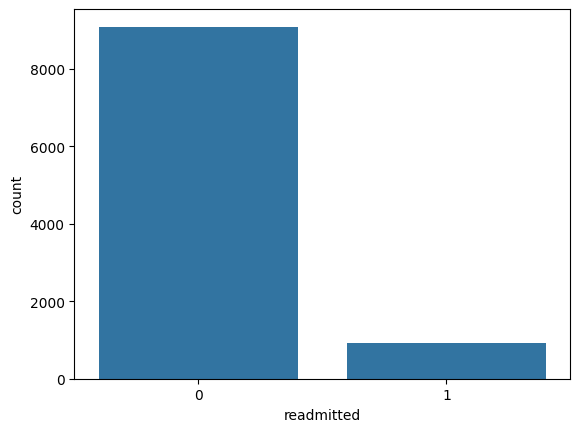

In [312]:
# Distribution of Readmission 
sns.countplot(x='readmitted', data=df.sample(10000))  

#### Time in Hospital and Readmission


C:\Users\vrajd\AppData\Local\Temp\ipykernel_16600\4190758192.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
C:\Users\vrajd\AppData\Local\Temp\ipykernel_16600\4190758192.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')


Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

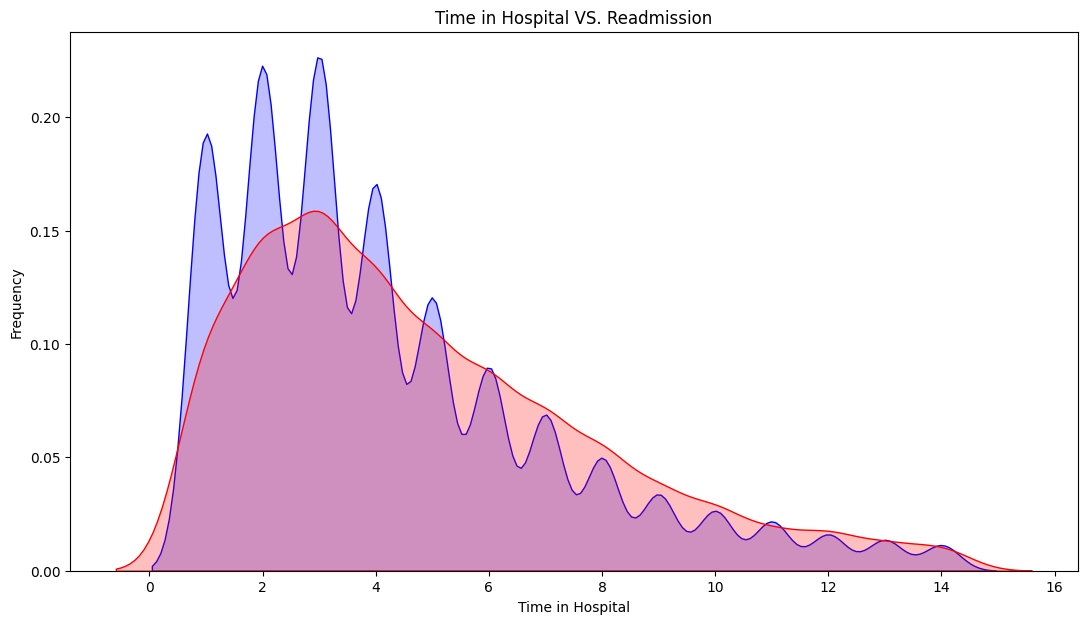

In [313]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

#### Age and Readmission

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

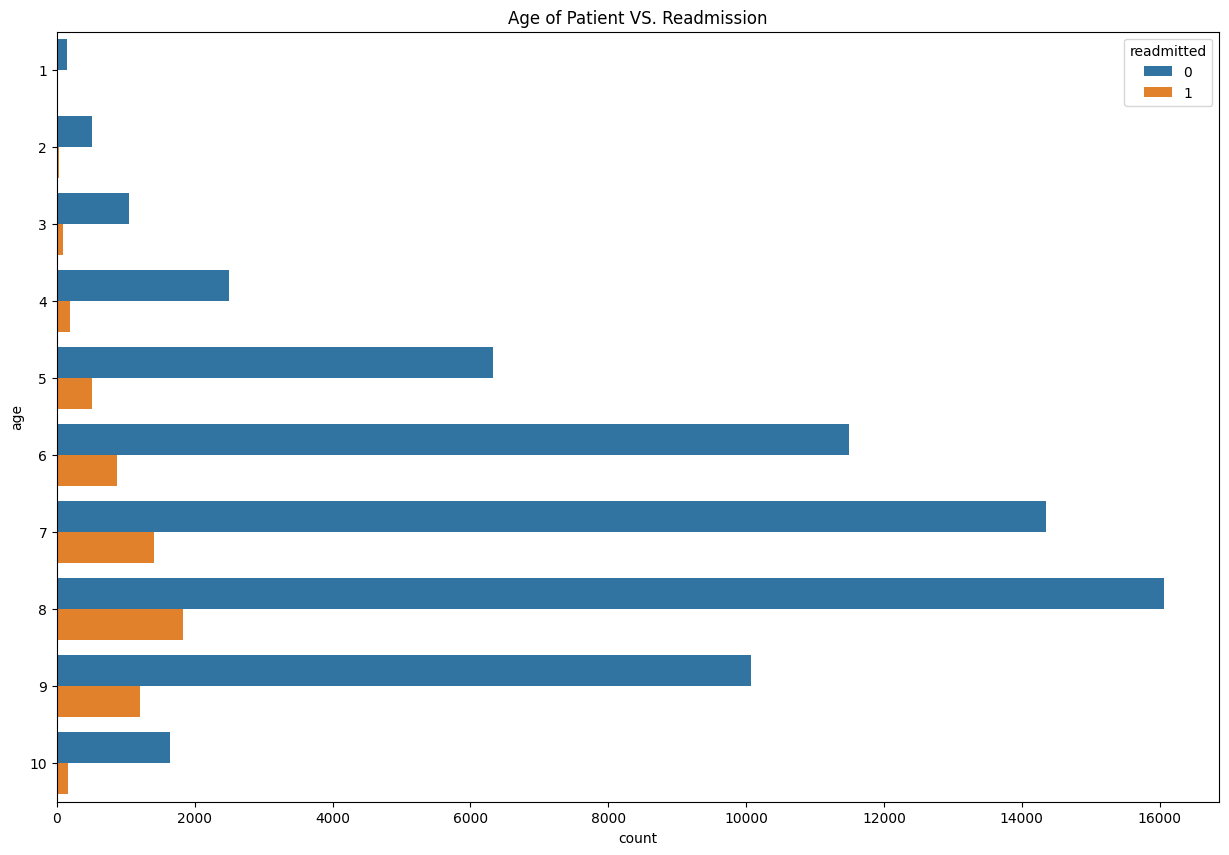

In [314]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

#### Number of medication used and Readmission

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

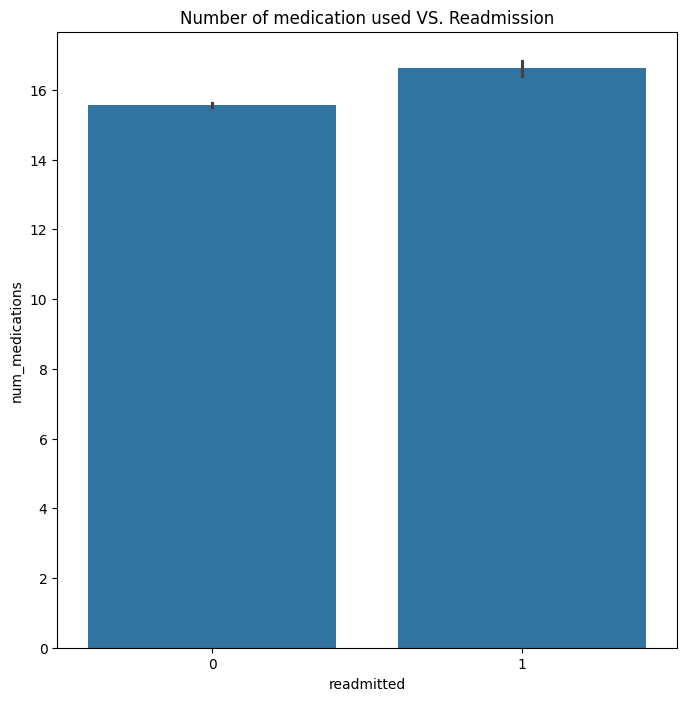

In [316]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

#### Gender and Readmission
* Male = 1
* Female = 0

<Axes: xlabel='gender', ylabel='count'>

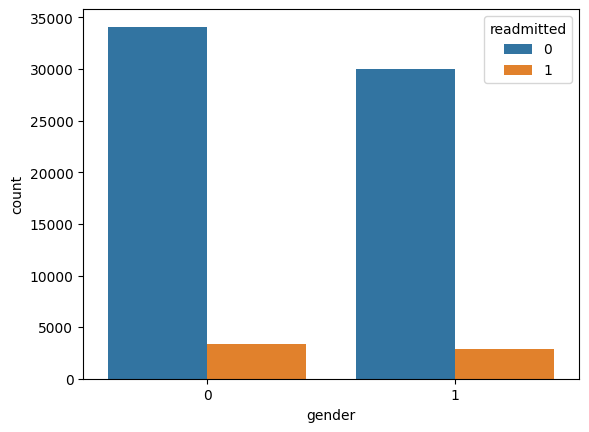

In [317]:
sns.countplot(x='gender', hue='readmitted', data=df)

#### Change of Medication and Readmission
* Change = 1
* No Change = 0

Text(0.5, 1.0, 'Change of Medication vs. Readmission')

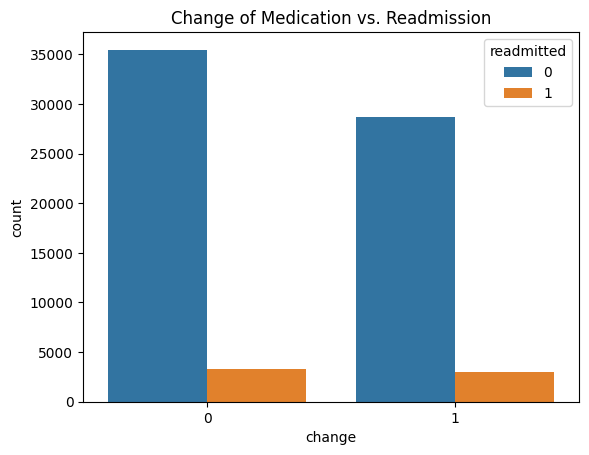

In [318]:
sns.countplot(x='change', hue='readmitted', data=df).set_title('Change of Medication vs. Readmission')

#### Diabetes Medication prescribed and Readmission
* Diabetes Medication - medications Nominal Indicates if there was any diabetic medication prescribed.
* Values: “yes” : 1 “no” : 0

Text(0.5, 1.0, 'Diabetes Medication Prescribed vs Readmission')

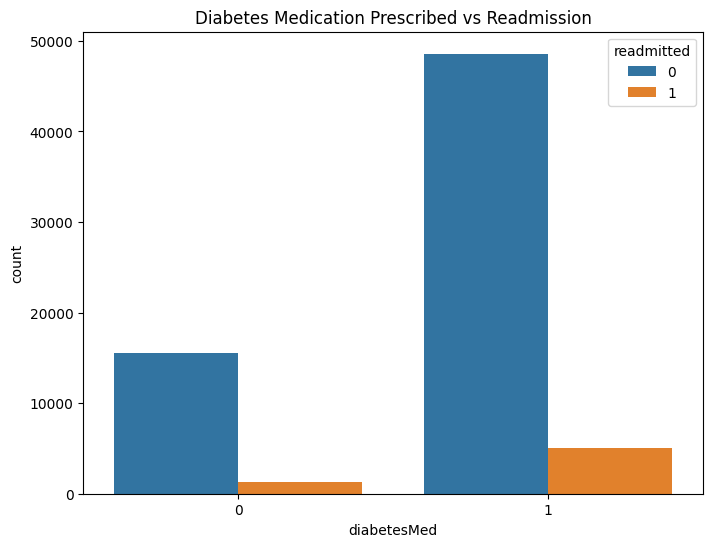

In [319]:
fig = plt.figure(figsize=(8, 6))
sns.countplot(x='diabetesMed', hue='readmitted', data=df).set_title('Diabetes Medication Prescribed vs Readmission')

#### Service Utilization and Readmission


Text(0.5, 1.0, 'Service Utilization VS. Readmission')

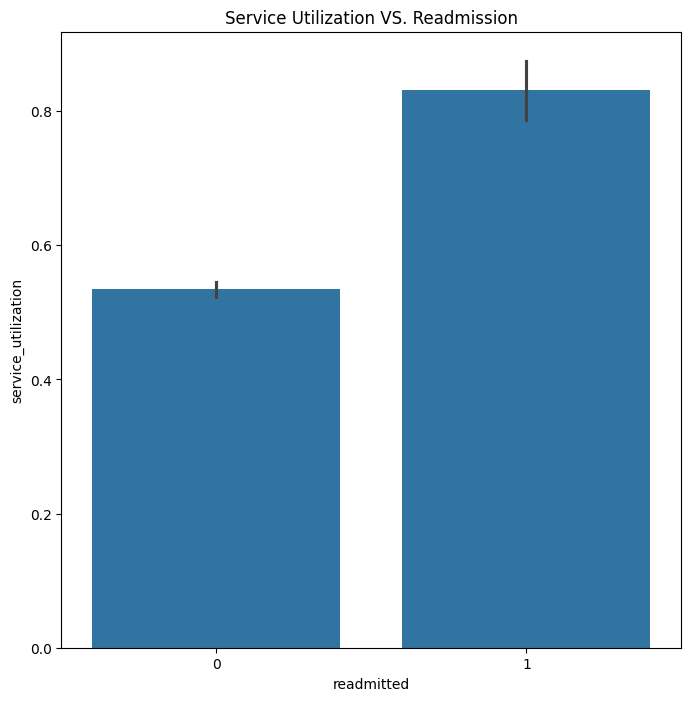

In [320]:
fig = plt.figure(figsize=(8,8))
sns.barplot( y = df['service_utilization'], x = df['readmitted']).set_title('Service Utilization VS. Readmission')

#### Number of lab procedure and Readmission

C:\Users\vrajd\AppData\Local\Temp\ipykernel_16600\1261402117.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
C:\Users\vrajd\AppData\Local\Temp\ipykernel_16600\1261402117.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')


Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

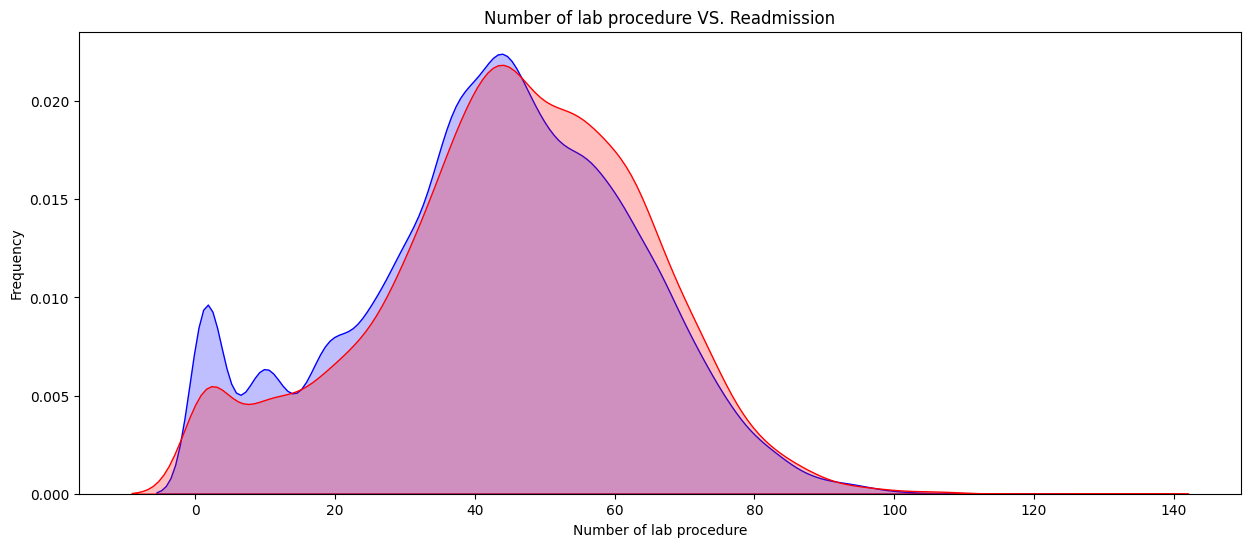

In [323]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')